In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 清洗并写入表

In [21]:
# raw_data是从原表读到的原始数据
raw_data = pd.read_excel(os.path.join(os.getcwd(),'data/rawdata/car_all_beijing.xls'))

In [22]:
raw_data = raw_data.rename(columns={
    '标题':'title',
    '价格':'price',
    '新车价格':'price_new',
    '首次上牌':'date_regi',
    '表显里程':'mileage', 
    '官方续航':'official_endurance',
    '排放标准':'standard',
    '变速箱':'gearbox',
    '过户次数':'num_trans',
    '车牌地':'license_location',
    '车身颜色':'color',
    '电动机总功率':'motor_power',
    '电池容量':'battery_capacity',
    '电池类型':'battery_type',
    '能源类型':'energy_type',
    '排量':'displacement',
    '钥匙数':'keys'
    })

In [23]:
print(raw_data.shape) # (39216, 17)
# 根据title去掉空行
not_null_raw_data = raw_data[~(raw_data['title'].isnull())]
print(not_null_raw_data.shape) # (39159, 17)
print('空行数量：',39216-39159)
print('查看每个列空值数量：')
print(not_null_raw_data.isnull().sum())

(19361, 17)
(19300, 17)
空行数量： 57
查看每个列空值数量：
title                     0
price                     0
price_new                 0
date_regi                 0
mileage                   0
official_endurance    14296
standard                  0
gearbox                   0
num_trans                 0
license_location          0
color                     0
motor_power           14296
battery_capacity      14296
battery_type          14296
energy_type               0
displacement           5004
keys                      0
dtype: int64


In [24]:
# 全部数据清洗

clean_data = not_null_raw_data.copy()
# title列拆c出brand
clean_data['brand'] = clean_data['title'].str.split(' ',expand=True)[0]
# 去掉单位
clean_data['mileage'] = clean_data['mileage'].str.replace('万公里','').apply(lambda x :float(x.replace('公里',''))/10000 if '公里' in str(x) else x).astype(np.float64)
clean_data['official_endurance'] = clean_data['official_endurance'].str.replace('km','').replace('-',np.nan).astype(np.float64)
clean_data['num_trans'] = clean_data['num_trans'].str.replace('次','').replace('-',np.nan).astype(np.float64)
clean_data['battery_capacity'] = clean_data['battery_capacity'].str.replace('kWh','').replace('-',np.nan).astype(np.float64)
clean_data['motor_power'] = clean_data['motor_power'].str.replace('kw','').replace('-',np.nan).astype(np.float64)
clean_data['keys'] = clean_data['keys'].str.replace('把','').astype(np.float64)

# location 一线城市（北上广深）为1，其他城市为0
clean_data['license_location'] = clean_data['license_location'].str.split('[(（]',expand=True)[0]
clean_data['license_location'] = clean_data['license_location'].apply(lambda x : 1 if x in ['上海','北京','广州','深圳'] else 0).astype(np.float64)

# color 黑色、白色、深灰色、银灰色为0，其他颜色为1
clean_data['color'] = clean_data['color'].apply(lambda x : 0 if x in ['白色','黑色','深灰色','银灰色'] else 1).astype(np.float64)

# displace：T*1.4变成L，方便分析，排放越大性能越好
clean_data['displacement'] = clean_data['displacement'].astype(str).apply(lambda x : float(x.replace('T',''))*1.4 if 'T' in x else float(x.replace('L',''))).astype(np.float64)

# 能源类型:汽油0，电动1，混合2
energy_type = list(clean_data['energy_type'].dropna().unique())
type_num = [2,0,1,2,2,2,2,0,2,2]
energy_type_num=dict(zip(energy_type,type_num))
clean_data['energy_type'] = clean_data['energy_type'].map(energy_type_num)

# 变速箱：手动0，自动1
clean_data['gearbox'] = clean_data['gearbox'].apply(lambda x : 1 if str(x)=='自动' else 0)

In [25]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19300 entries, 0 to 19360
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               19300 non-null  object 
 1   price               19300 non-null  float64
 2   price_new           19300 non-null  float64
 3   date_regi           19300 non-null  object 
 4   mileage             19300 non-null  float64
 5   official_endurance  4998 non-null   float64
 6   standard            19300 non-null  object 
 7   gearbox             19300 non-null  int64  
 8   num_trans           19300 non-null  float64
 9   license_location    19300 non-null  float64
 10  color               19300 non-null  float64
 11  motor_power         5003 non-null   float64
 12  battery_capacity    4849 non-null   float64
 13  battery_type        5004 non-null   object 
 14  energy_type         19300 non-null  int64  
 15  displacement        14296 non-null  float64
 16  keys

In [26]:
# 挑出油车
petrol = clean_data[clean_data['energy_type']==0]
# 删除电车特征
petrol_not_null = petrol.drop(['official_endurance','motor_power','battery_capacity','battery_type'],axis=1)

In [27]:
#电车
electric = clean_data[clean_data['energy_type']==1]
# 均值motor_power、battery_capacity、official_endurance # 众数battery_type #删除displacement
electric['motor_power'].fillna(electric['motor_power'].mean(), inplace=True)
electric['battery_capacity'].fillna(electric['battery_capacity'].mean(), inplace=True)
electric['official_endurance'].fillna(electric['official_endurance'].mean(), inplace=True)
electric['battery_type'].fillna('三元锂电池', inplace=True)
electric = electric.drop(['displacement'],axis=1)

/var/folders/hv/0r6f95ls1ss09znhzxqsj0nr0000gn/T/ipykernel_39875/550047704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electric['motor_power'].fillna(electric['motor_power'].mean(), inplace=True)
/var/folders/hv/0r6f95ls1ss09znhzxqsj0nr0000gn/T/ipykernel_39875/550047704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electric['battery_capacity'].fillna(electric['battery_capacity'].mean(), inplace=True)
/var/folders/hv/0r6f95ls1ss09znhzxqsj0nr0000gn/T/ipykernel_39875/550047704.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [28]:
# 写文件
def write_xlsx(df,path, sheetName):
    writer = pd.ExcelWriter(path, engine='openpyxl',mode='a', if_sheet_exists="overlay")
    df.to_excel(writer, sheet_name=sheetName)
    writer.close()

In [29]:
# 写入同一个文件三张表
path = 'data/cleaneddata/cleaned_car_beijing_all.xlsx'
pd.DataFrame().to_excel(path,sheet_name='total') # 先创建文件
write_xlsx(petrol,path,'petrol')
write_xlsx(electric, path,'electric')
write_xlsx(clean_data, path,'total')

# 数据分析

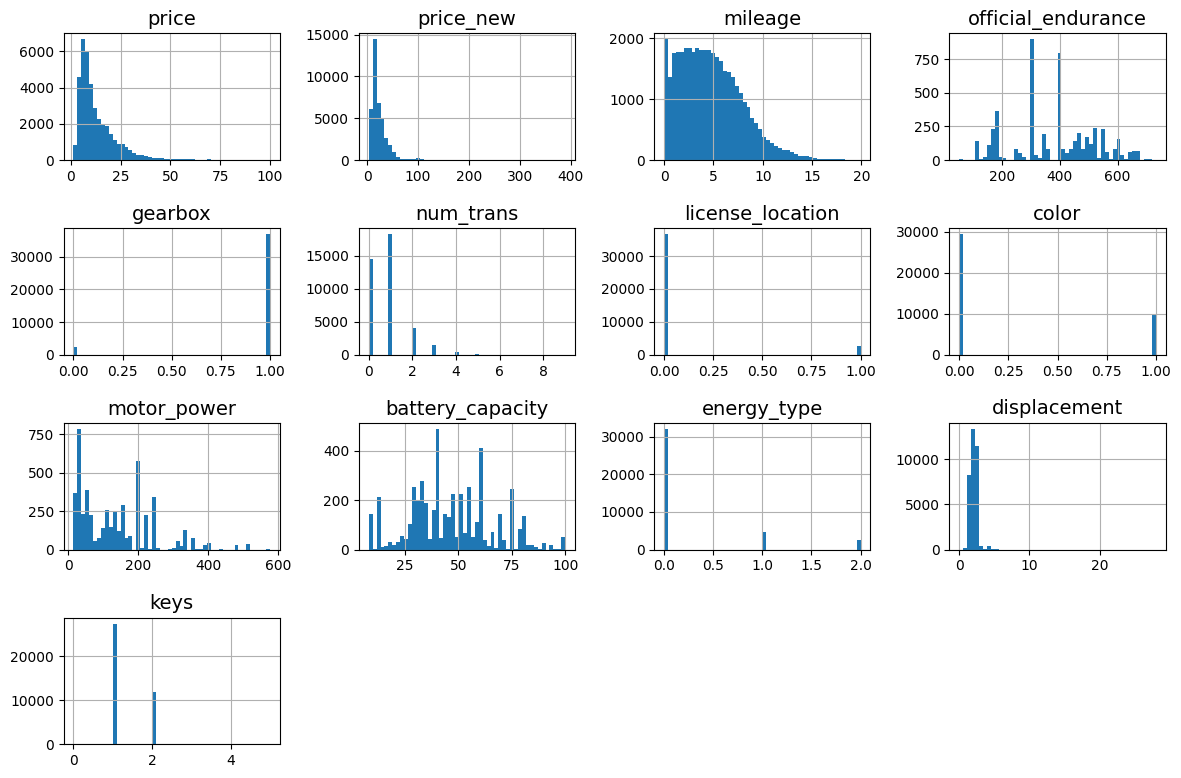

In [11]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

clean_data.hist(bins=50, figsize=(12, 8))
plt.tight_layout()

In [13]:
corr_data_matrix = clean_data.corr()
corr_data_matrix['price'].sort_values(ascending=False)

price                 1.000000
price_new             0.891951
motor_power           0.888454
battery_capacity      0.717950
displacement          0.660271
official_endurance    0.520394
gearbox               0.212435
energy_type           0.190409
keys                  0.088873
num_trans             0.079684
license_location      0.074309
color                -0.028627
mileage              -0.084578
Name: price, dtype: float64

array([[<AxesSubplot: xlabel='price', ylabel='price'>,
        <AxesSubplot: xlabel='price_new', ylabel='price'>,
        <AxesSubplot: xlabel='motor_power', ylabel='price'>,
        <AxesSubplot: xlabel='battery_capacity', ylabel='price'>,
        <AxesSubplot: xlabel='displacement', ylabel='price'>,
        <AxesSubplot: xlabel='official_endurance', ylabel='price'>],
       [<AxesSubplot: xlabel='price', ylabel='price_new'>,
        <AxesSubplot: xlabel='price_new', ylabel='price_new'>,
        <AxesSubplot: xlabel='motor_power', ylabel='price_new'>,
        <AxesSubplot: xlabel='battery_capacity', ylabel='price_new'>,
        <AxesSubplot: xlabel='displacement', ylabel='price_new'>,
        <AxesSubplot: xlabel='official_endurance', ylabel='price_new'>],
       [<AxesSubplot: xlabel='price', ylabel='motor_power'>,
        <AxesSubplot: xlabel='price_new', ylabel='motor_power'>,
        <AxesSubplot: xlabel='motor_power', ylabel='motor_power'>,
        <AxesSubplot: xlabel='battery_c

<Figure size 640x480 with 0 Axes>

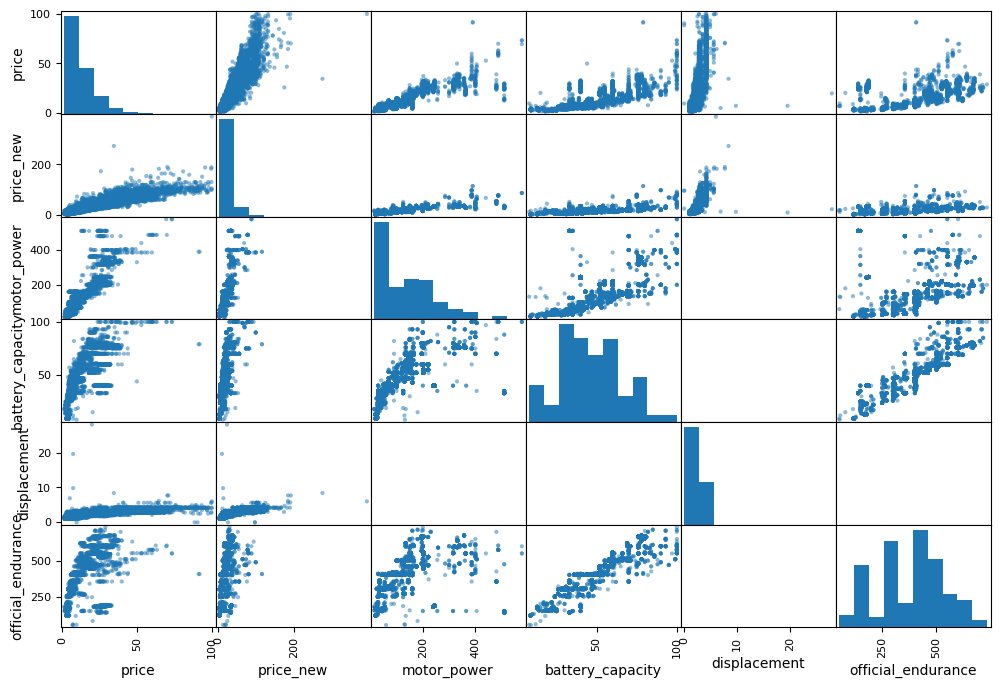

In [11]:
from pandas.plotting import scatter_matrix

attributes = [
    "price",
    "price_new", 
    "motor_power", 
    "battery_capacity", 
    "displacement",
    "official_endurance"
]
plt.tight_layout()
scatter_matrix(clean_data[attributes], figsize=(12, 8))